In [37]:
from pathlib import Path
from datetime import timedelta
import os
import math
import zipfile
import re
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
from tqdm import tqdm
import json
from shapely.geometry import box
import requests
from pystac_client import Client
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import transform_geom
from rasterio.mask import mask
import numpy as np

In [38]:
def utm_epsg_from_lonlat(lon: float, lat: float) -> str:
    zone = int((lon + 180) // 6) + 1
    epsg = 32600 + zone if lat >= 0 else 32700 + zone
    return f"EPSG:{epsg}"

In [36]:
def create_aois(input_folder, target_crs="EPSG:4326"):
    input_folder = Path(input_folder)
    files = sorted([f for pat in ("*.geojson", "*.gpkg") for f in input_folder.glob(pat)])
    if not files:
        print("No .geojson or .gpkg files found; nothing to do.")
        return None
    
    gdfs = []
    for file in tqdm(files, total=len(files), desc="Reading AOIs"):
        gdf = gpd.read_file(file)
        if gdf.crs is None:
            if file.suffix.lower() == ".geojson":
                gdf = gdf.set_crs("EPSG:4326", allow_override=True)
            else:
                print(f"WARNING: {file.name} has no CRS; skipping.")
                continue
        
        if gdf.crs.to_string() != target_crs:
            gdf = gdf.to_crs(target_crs)
        
        parts = file.stem.split("_")
        gdf["filename"]     = file.name
        gdf["region"]       = parts[0] if len(parts) > 0 else None
        gdf["target"]       = parts[1] if len(parts) > 1 else None
        gdf["date_raw"]     = parts[2] if len(parts) > 2 else None
        gdf["resolution"]   = parts[3] if len(parts) > 3 else None
        gdf["tile"]         = parts[4] if len(parts) > 4 else None
        
        gdfs.append(gdf)
    
    # Drop empties and all-NA columns to avoid FutureWarning on concat
    gdfs_clean = []
    for df in gdfs:
        if df is None or df.empty:
            continue
        gdfs_clean.append(df.dropna(axis=1, how="all"))
    
    if not gdfs_clean:
        print("No valid AOIs after CRS checks.")
        return None
    
    merged = gpd.GeoDataFrame(pd.concat(gdfs_clean, ignore_index=True), crs=target_crs)
    merged["date"] = pd.to_datetime(
        merged["date_raw"].where(merged["date_raw"].astype(str).str.fullmatch(r"\d{8}")),
        format="%Y%m%d",
        errors="coerce"
    )
    
    cols = ["filename", "region", "target", "date", "resolution", "tile", "geometry"]
    merged = merged[[c for c in cols if c in merged.columns]].copy()
    
    # dissolve by target
    dissolved = merged.dissolve(by="target", as_index=True).reset_index()
    
    # Compute centroids in projected CRS (EPSG:3413), then convert to WGS84
    tmp = dissolved.to_crs("EPSG:3413")
    cent = tmp.geometry.centroid.to_crs("EPSG:4326")
    dissolved["centroid_lon"] = cent.x
    dissolved["centroid_lat"] = cent.y
    
    dissolved["utm_epsg"] = dissolved.apply(
        lambda r: utm_epsg_from_lonlat(r["centroid_lon"], r["centroid_lat"]), 
        axis=1
    )
    
    return dissolved

,target,aoi_date,img_date,date_diff
0,Aklavik,2023-07-15,2023-07-09,-6 days
1,Aklavik,2023-07-15,2023-07-09,-6 days
2,AnaktuvukRiverFire,2019-07-22,2019-07-23,1 days
3,AnaktuvukRiverFire,2019-07-22,2019-07-23,1 days
4,AnaktuvukRiverFire,2019-07-22,2019-07-23,1 days
...,...,...,...,...
300,YukonCoast,2023-07-21,2023-07-22,1 days
301,YukonCoast,2023-07-21,2023-07-22,1 days
302,YukonCoast,2023-07-21,2023-07-22,1 days
303,YukonCoast,2023-07-21,2023-07-22,1 days


target          TrailValleyCreek
aoi_date     2018-08-22 00:00:00
img_date     2023-07-07 00:00:00
date_diff     1780 days 00:00:00
Name: 265, dtype: object
target             IkpikpukDelta
aoi_date     2019-07-31 00:00:00
img_date     2019-07-12 00:00:00
date_diff     -19 days +00:00:00
Name: 106, dtype: object


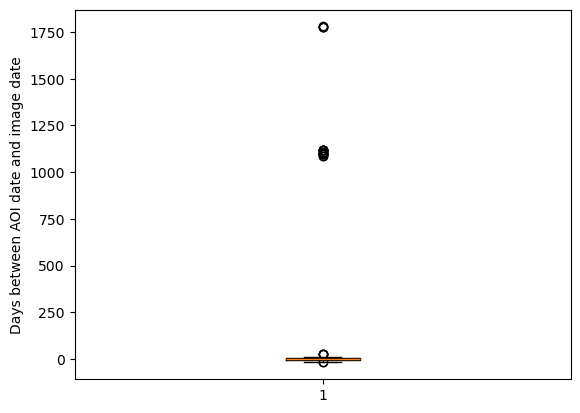

In [39]:
aois = r'n:\isipd\projects\p_planetdw\data\methods_test\download\merged_aois.geojson'
img_for_aois = r'n:\isipd\projects\p_planetdw\data\methods_test\S2_GEE_export_summary.csv'

gdf = gpd.read_file(aois)
img_df = pd.read_csv(img_for_aois, parse_dates=['Date'])

#join gdf to img_df by Target
gdf_merged = gdf.merge(img_df, left_on='target', right_on='AOI', how='left')

# rename date to aoi_date and Date to img_date
gdf_merged = gdf_merged.rename(columns={'date': 'aoi_date', 'Date': 'img_date'})
gdf_merged['date_diff'] = (gdf_merged['img_date'] - gdf_merged['aoi_date'])

display(gdf_merged[['target', 'aoi_date', 'img_date', 'date_diff']])

from matplotlib import pyplot as plt

plt.boxplot(gdf_merged['date_diff'].dt.days.dropna())
plt.ylabel('Days between AOI date and image date')

#get highest and lowest date_diff, and the target area
print(gdf_merged.loc[gdf_merged['date_diff'].idxmax()][['target', 'aoi_date', 'img_date', 'date_diff']])
print(gdf_merged.loc[gdf_merged['date_diff'].idxmin()][['target', 'aoi_date', 'img_date', 'date_diff']])



In [34]:
#!/usr/bin/env python3
"""
Time-domain driving kinetosis analysis with intersections + elevation (SRTM)
Place: Blankenburg (Harz) + 10 km

- Simulates driving along every road (time step dt).
- Slowdowns at intersections (degree>=3) and stops at traffic signals.
- Computes instantaneous fx(t), fy(t), fz(t) with a temporal window.
- Maps to human sensitivity -> KRI(t).
- Exports time-series CSV, GeoJSON points, and a Leaflet map highlighting worst moments.

Requires:
    pip install overpy pyproj folium srtm.py
"""

import math
import re
import csv
import json
from collections import defaultdict, deque
from typing import List, Tuple, Dict, Optional

import overpy
from pyproj import Geod
import folium
import srtm  # package "srtm.py"

# ====================== CONFIG ======================

PLACE_NAME = "Blankenburg (Harz)"
AROUND_METERS = 10_000
HWY_REGEX = r"^(motorway|trunk|primary|secondary|tertiary|unclassified|residential|living_street|service|track)$"

# --- Temporal simulation ---
DT = 0.5                 # seconds between samples
TEMP_WINDOW_S = 30      # seconds for local frequency estimation around current position

# Sliding geometry window fallback (used for elevation wavelength if speed is tiny)
SPATIAL_MIN_WINDOW_M = 20.0

# Densification for geometry/elevation sampling (meters)
DENSIFY_STEP_M = 2.0

# Default speeds if maxspeed missing (km/h)
DEFAULT_SPEED_BY_HIGHWAY = {
    "motorway": 120, "trunk": 100, "primary": 100, "secondary": 70, "tertiary": 50,
    "unclassified": 50, "residential": 30, "living_street": 7, "service": 20, "track": 15
}
GLOBAL_SPEED_MULTIPLIER = 1.0

# Intersections / signals behavior (meters & speeds)
SLOW_ZONE_BEFORE_M = 30.0     # distance before junction to start slowing
SLOW_ZONE_AFTER_M  = 15.0     # distance after junction
SLOW_SPEED_KMH     = 12.0     # crawl through minor junctions
SIGNAL_STOP_TIME_S = 3.0      # dwell time at traffic signals (synthetic)
SIGNAL_APPROACH_SPEED_KMH = 5.0

# Surface → vertical wavelength proxy (meters) (fallback if elevation flat)
SURFACE_WAVELENGTH_M = {
    "asphalt": 8.0, "paved": 7.0, "concrete": 6.0, "concrete:lanes": 5.0, "sett": 2.0,
    "unpaved": 2.5, "compacted": 3.0, "fine_gravel": 3.5, "gravel": 2.0, "ground": 2.0,
    "dirt": 1.5, "earth": 1.5, "sand": 1.2, "grass": 1.2, "cobblestone": 1.0, "wood": 3.0
}
DEFAULT_VERTICAL_WAVELENGTH = 5.0

# Event thresholds
TURN_DEG_THRESHOLD = 5.0
MIN_EVENT_SPACING  = 5.0
TRAFFIC_CALMING_MIN_SPACING = 12.0

# Human sensitivity (bell curves around provocative bands)
SENS_LONG = {"f0": 0.20, "bw": 0.15}
SENS_LAT  = {"f0": 0.25, "bw": 0.15}
SENS_VERT = {"f0": 0.30, "bw": 0.20}

# Axis weights for KRI
WEIGHT_X, WEIGHT_Y, WEIGHT_Z = 0.15, 0.35, 0.50

# Outputs
OUT_HTML   = "blankenburg_drivetime_map.html"
OUT_GEOJSON= "blankenburg_drivetime_points.geojson"
OUT_CSV    = "blankenburg_drivetime_timeseries.csv"

# ====================================================

geod = Geod(ellps="WGS84")
api = overpy.Overpass()
elev_data = srtm.get_data()

# ---------------- Overpass ----------------

def overpass_query(place: str, around_m: int, hwy_regex: str) -> overpy.Result:
    q = f"""
    [out:json][timeout:180];
    area["boundary"="administrative"]["name"="{place}"]->.cityArea;
    node[place~"^(city|town|village)$"]["name"="{place}"]->.cityCenter;

    way(area.cityArea)["highway"]["highway"~"{hwy_regex}"]->.roads_in;
    way(around.cityCenter:{around_m})["highway"]["highway"~"{hwy_regex}"]->.roads_around;

    (.roads_in; .roads_around;)->.roads;

    // enrich: traffic calming + traffic signals on these ways
    node(w.roads)["traffic_calming"]->.tc_nodes;
    node(w.roads)["highway"="traffic_signals"]->.sig_nodes;

    (.roads; .tc_nodes; .sig_nodes;);
    out body;
    >;
    out skel qt;
    """
    return api.query(q)

# -------------- Geometry helpers --------------

def seg_length_m(p1: Tuple[float,float], p2: Tuple[float,float]) -> float:
    (lon1, lat1), (lon2, lat2) = p1, p2
    _, _, d = geod.inv(lon1, lat1, lon2, lat2)
    return d

def line_length_m(coords: List[Tuple[float, float]]) -> float:
    if len(coords) < 2: return 0.0
    total = 0.0
    for a, b in zip(coords[:-1], coords[1:]):
        total += seg_length_m(a, b)
    return total

def headings_deg(coords: List[Tuple[float, float]]) -> List[float]:
    hs = []
    for (lon1, lat1), (lon2, lat2) in zip(coords[:-1], coords[1:]):
        az, _, _ = geod.inv(lon1, lat1, lon2, lat2)
        hs.append((az + 360.0) % 360.0)
    return hs

def delta_heading_deg(h1: float, h2: float) -> float:
    d = h2 - h1
    return (d + 180.0) % 360.0 - 180.0

def densify_by_distance(coords: List[Tuple[float,float]], step_m: float) -> List[Tuple[float,float]]:
    if len(coords) < 2: return coords[:]
    out = [coords[0]]
    acc = 0.0
    prev = coords[0]
    for nxt in coords[1:]:
        d = seg_length_m(prev, nxt)
        if d <= 0:
            continue
        walked = 0.0
        while acc + (d - walked) >= step_m:
            need = step_m - acc
            t = (walked + need) / d
            lon = prev[0] + (nxt[0] - prev[0]) * t
            lat = prev[1] + (nxt[1] - prev[1]) * t
            out.append((lon, lat))
            walked += need
            acc = 0.0
        acc += d - walked
        prev = nxt
    if out[-1] != coords[-1]:
        out.append(coords[-1])
    return out

# -------------- Elevation helpers --------------

def get_elev(lat: float, lon: float) -> Optional[float]:
    e = elev_data.get_elevation(lat, lon)
    return float(e) if e is not None else None

def fill_nans_inplace(vals: List[Optional[float]]) -> List[Optional[float]]:
    n = len(vals)
    last = None
    for i in range(n):
        if vals[i] is None and last is not None:
            vals[i] = last
        elif vals[i] is not None:
            last = vals[i]
    last = None
    for i in reversed(range(n)):
        if vals[i] is None and last is not None:
            vals[i] = last
        elif vals[i] is not None:
            last = vals[i]
    return vals

def detrend_linear(y: List[float]) -> List[float]:
    n = len(y)
    if n <= 1: return [0.0]*n
    y0, y1 = y[0], y[-1]
    return [y[i] - (y0 + (i/(n-1))*(y1-y0)) for i in range(n)]

def extrema_indices_from_slopes(y: List[float]) -> List[int]:
    if len(y) < 3: return []
    slopes = [y[i+1]-y[i] for i in range(len(y)-1)]
    idx = []
    for i in range(1, len(slopes)):
        if (slopes[i-1] > 0 and slopes[i] <= 0) or (slopes[i-1] < 0 and slopes[i] >= 0):
            idx.append(i)
    return idx

def mean_distance_between_indices(coords: List[Tuple[float,float]], idx: List[int]) -> float:
    if len(idx) < 2: return 0.0
    dists = [line_length_m(coords[a:b+1]) for a,b in zip(idx[:-1], idx[1:])]
    return sum(dists)/len(dists) if dists else 0.0

def effective_vertical_wavelength_from_elevation(coords: List[Tuple[float,float]]) -> Optional[float]:
    if len(coords) < 3: return None
    lats = [lat for (lon,lat) in coords]
    lons = [lon for (lon,lat) in coords]
    elev = [get_elev(lat, lon) for lat,lon in zip(lats,lons)]
    if all(e is None for e in elev): return None
    elev = fill_nans_inplace(elev)
    if any(e is None for e in elev): return None
    detr = detrend_linear(elev)
    rng = max(detr) - min(detr)
    if rng < 0.05: return None
    extrema_idx = extrema_indices_from_slopes(detr)
    if len(extrema_idx) < 2: return None
    half_wave = mean_distance_between_indices(coords, extrema_idx)
    if half_wave <= 0: return None
    return 2.0*half_wave

# -------------- Parsing + risk --------------

def parse_speed_kmh(maxspeed: Optional[str], highway: Optional[str]) -> float:
    if maxspeed:
        s = maxspeed.strip().lower()
        if s in {"walk","walking"}: return 5.0
        m = re.search(r"(\d+(\.\d+)?)\s*(km/h|kph|mph)?", s)
        if m:
            val = float(m.group(1)); unit = (m.group(3) or "km/h").lower()
            return val*1.60934 if unit=="mph" else val
    return float(DEFAULT_SPEED_BY_HIGHWAY.get((highway or "").lower(), 40))

def bandpass_score(f: float, f0: float, bw: float) -> float:
    if f <= 0: return 0.0
    return math.exp(-((f - f0) / bw) ** 2)

def kri_color(v: float) -> str:
    v = max(0.0, min(100.0, v))
    if v <= 50:
        t = v/50.0; r,g,b = t, 1.0, 0.0
    else:
        t = (v-50.0)/50.0; r,g,b = 1.0, 1.0-t, 0.0
    return "#{:02x}{:02x}{:02x}".format(int(r*255), int(g*255), 0)

# =============== Time-domain simulation helpers ===============

def build_speed_profile_along_s(s_coords: List[float],
                                base_v_kmh: float,
                                junction_s: List[float],
                                signal_s: List[float]) -> List[float]:
    """
    Produce speed (m/s) at each densified vertex as a function of arc length s,
    slowing near junctions; near signals, slow to crawl then synthetic stop.
    We don't physically simulate stop dwell here; dwell is handled in the time stepping.
    """
    base_v_ms = max(0.1, base_v_kmh/3.6)
    slow_ms = max(0.5, SLOW_SPEED_KMH/3.6)
    signal_ms = max(0.1, SIGNAL_APPROACH_SPEED_KMH/3.6)

    def nearest_event_distance(si: float, events: List[float]) -> float:
        # events and s_coords are nondecreasing
        if not events: return float("inf")
        # binary search for closest
        lo, hi = 0, len(events)-1
        while hi - lo > 1:
            mid = (lo+hi)//2
            if events[mid] < si: lo = mid
            else: hi = mid
        return min(abs(si - events[lo]), abs(si - events[hi]))

    v = []
    for si in s_coords:
        d_junc = nearest_event_distance(si, junction_s)
        d_sig  = nearest_event_distance(si, signal_s)
        # junction slow zone
        if d_sig <= SLOW_ZONE_BEFORE_M:
            # approach signal slower than junction
            frac = max(0.0, (d_sig)/SLOW_ZONE_BEFORE_M)  # 0 at signal, 1 at edge
            vv = signal_ms + (base_v_ms - signal_ms)*frac
        elif d_junc <= SLOW_ZONE_BEFORE_M:
            frac = max(0.0, (d_junc)/SLOW_ZONE_BEFORE_M)
            vv = slow_ms + (base_v_ms - slow_ms)*frac
        else:
            vv = base_v_ms
        v.append(vv)
    return v

def cumulative_s(coords: List[Tuple[float,float]]) -> List[float]:
    s = [0.0]
    for a,b in zip(coords[:-1], coords[1:]):
        s.append(s[-1] + seg_length_m(a,b))
    return s

def interpolate_along_s(coords: List[Tuple[float,float]], s_coords: List[float], s: float) -> Tuple[float,float,int]:
    """
    Interpolate lon,lat at arc length s. Returns (lon,lat,index_hi)
    index_hi is the upper vertex index such that s is between [i-1, i].
    """
    if s <= 0: return coords[0][0], coords[0][1], 1
    if s >= s_coords[-1]: return coords[-1][0], coords[-1][1], len(coords)-1
    # binary search
    lo, hi = 0, len(s_coords)-1
    while hi - lo > 1:
        mid = (lo+hi)//2
        if s_coords[mid] < s: lo = mid
        else: hi = mid
    s0, s1 = s_coords[lo], s_coords[hi]
    if s1 == s0: 
        return coords[hi][0], coords[hi][1], hi
    t = (s - s0)/(s1 - s0)
    lon = coords[lo][0] + t*(coords[hi][0]-coords[lo][0])
    lat = coords[lo][1] + t*(coords[hi][1]-coords[lo][1])
    return lon, lat, hi

def spatial_window_indices(s_coords: List[float], s_center: float, window_m: float) -> Tuple[int,int]:
    a = s_center - window_m/2.0
    b = s_center + window_m/2.0
    i0 = max(0, next((i for i,v in enumerate(s_coords) if v >= a), 0))
    i1 = max(i0+1, next((i for i,v in enumerate(s_coords) if v >= b), len(s_coords)-1))
    return i0, i1

# =============== Main ===============

def main():
    print("Querying Overpass…")
    result = overpass_query(PLACE_NAME, AROUND_METERS, HWY_REGEX)

    # node→ways (for junctions)
    node_to_wayids: Dict[str, set] = defaultdict(set)
    for w in result.ways:
        for n in w.nodes:
            node_to_wayids[n.id].add(w.id)
    junction_nodes = {nid for nid, wids in node_to_wayids.items() if len(wids) >= 3}

    # traffic calming & signals
    tc_node_ids  = {n.id for n in result.nodes if "traffic_calming" in n.tags}
    sig_node_ids = {n.id for n in result.nodes if n.tags.get("highway") == "traffic_signals"}

    # center for map
    centers = [n for n in result.nodes if n.tags.get("place") in {"city","town","village"} and n.tags.get("name")==PLACE_NAME]
    if centers:
        center_lon, center_lat = float(centers[0].lon), float(centers[0].lat)
    else:
        anyw = result.ways[0]
        center_lon, center_lat = float(anyw.nodes[0].lon), float(anyw.nodes[0].lat)

    # Map + layers
    fmap = folium.Map(location=[center_lat, center_lon], zoom_start=13, control_scale=True)
    layer_pts = folium.FeatureGroup(name="Drive-time samples (worst 10% KRI)", show=True)

    # Time-series CSV
    csv_rows = []
    # GeoJSON points
    gj_features = []

    for w in result.ways:
        tags = w.tags
        hwy  = tags.get("highway","")
        name = tags.get("name","(unnamed)")
        surface = (tags.get("surface") or "").lower()
        v_kmh = parse_speed_kmh(tags.get("maxspeed"), hwy) * GLOBAL_SPEED_MULTIPLIER

        raw = [(float(n.lon), float(n.lat)) for n in w.nodes]
        if len(raw) < 2: continue

        # Densify for time simulation & elevation
        coords = densify_by_distance(raw, DENSIFY_STEP_M)
        if len(coords) < 2: continue

        # Arc-lengths and headings
        s_coords = cumulative_s(coords)
        total_len = s_coords[-1]
        heads = headings_deg(coords)

        # Mark events along s
        junction_s = []
        signal_s   = []
        tc_s       = []

        # Map original nodes to densified s using cumulative distance mapping
        # Build cum for raw nodes
        s_raw = cumulative_s(raw)

        # helper: nearest densified index for raw arc s
        def nearest_den_idx_from_s(sr: float) -> int:
            lo, hi = 0, len(s_coords)-1
            while hi - lo > 1:
                mid = (lo+hi)//2
                if s_coords[mid] < sr: lo = mid
                else: hi = mid
            return lo if abs(s_coords[lo]-sr) <= abs(s_coords[hi]-sr) else hi

        for i, node in enumerate(w.nodes):
            sr = s_raw[i]
            j = nearest_den_idx_from_s(sr)
            if node.id in junction_nodes:
                junction_s.append(s_coords[j])
            if node.id in sig_node_ids:
                signal_s.append(s_coords[j])
            if node.id in tc_node_ids:
                tc_s.append(s_coords[j])

        junction_s.sort(); signal_s.sort(); tc_s.sort()

        # Build speed profile vs s (m)
        v_profile = build_speed_profile_along_s(s_coords, v_kmh, junction_s, signal_s)  # m/s

        # Time march along s with DT, including synthetic stops at signals
        t = 0.0
        s_pos = 0.0
        i_sig_next = 0
        # precompute signals as queue for dwell
        sig_queue = deque(signal_s)

        # store samples for this way to compute percentiles later
        way_samples = []

        while s_pos < total_len - 0.1:
            # Check if we’re entering a signal stop zone
            if sig_queue and s_pos >= sig_queue[0] - 1.0 and s_pos <= sig_queue[0] + 1.0:
                # dwell stop
                for _ in range(int(SIGNAL_STOP_TIME_S/DT)):
                    lon, lat, _ = interpolate_along_s(coords, s_coords, s_pos)
                    # During dwell, speed≈0; use spatial fallback window
                    v_curr = 0.01
                    win_m = max(SPATIAL_MIN_WINDOW_M, v_curr * TEMP_WINDOW_S)

                    # compute instantaneous freqs from events/elevation near s_pos
                    fx, fy, fz, kri = instantaneous_metrics(coords, s_coords, heads, s_pos, v_curr,
                                                            win_m, surface, junction_s, tc_s)
                    row = {
                        "t_s": round(t,2), "lon": lon, "lat": lat, "road": name, "highway": hwy,
                        "speed_mps": 0.0, "speed_kmh": 0.0,
                        "fx_hz": fx, "fy_hz": fy, "fz_hz": fz, "KRI": kri, "state": "signal_stop"
                    }
                    csv_rows.append(row)
                    way_samples.append((lat, lon, kri))
                    t += DT
                # clear this signal (passed)
                sig_queue.popleft()
                continue

            # normal advance
            # interpolate speed at current s_pos using nearest vertex index
            _, _, hi = interpolate_along_s(coords, s_coords, s_pos)
            v_curr = max(0.1, v_profile[hi])  # m/s
            ds = v_curr * DT
            s_next = min(total_len, s_pos + ds)

            # temporal window -> spatial window length
            win_m = max(SPATIAL_MIN_WINDOW_M, v_curr * TEMP_WINDOW_S)

            # metrics
            fx, fy, fz, kri = instantaneous_metrics(coords, s_coords, heads, s_pos, v_curr,
                                                    win_m, surface, junction_s, tc_s)

            lon, lat, _ = interpolate_along_s(coords, s_coords, s_pos)
            row = {
                "t_s": round(t,2), "lon": lon, "lat": lat, "road": name, "highway": hwy,
                "speed_mps": round(v_curr,3), "speed_kmh": round(v_curr*3.6,2),
                "fx_hz": fx, "fy_hz": fy, "fz_hz": fz, "KRI": kri, "state": "moving"
            }
            csv_rows.append(row)
            way_samples.append((lat, lon, kri))

            # step
            s_pos = s_next
            t += DT

        # Add top 10% KRI points from this way to map & GeoJSON
        if way_samples:
            sorted_by_kri = sorted(way_samples, key=lambda x: x[2], reverse=True)
            cutoff_index = max(1, int(0.10*len(sorted_by_kri)))
            worst = sorted_by_kri[:cutoff_index]
            for lat, lon, kri in worst:
                folium.CircleMarker(
                    location=(lat, lon), radius=3, weight=0,
                    color=kri_color(kri), fill=True, fill_opacity=0.9,
                    tooltip=f"{name} ({hwy}) KRI={kri:.0f}"
                ).add_to(layer_pts)
                gj_features.append({
                    "type":"Feature",
                    "geometry":{"type":"Point","coordinates":[lon,lat]},
                    "properties":{"road":name, "highway":hwy, "KRI":round(kri,1)}
                })

    # Map
    layer_pts.add_to(fmap)
    folium.LayerControl(collapsed=False).add_to(fmap)
    fmap.save(OUT_HTML)
    print(f"✅ Map written: {OUT_HTML}")

    # GeoJSON
    gj = {"type":"FeatureCollection","features":gj_features}
    with open(OUT_GEOJSON,"w",encoding="utf-8") as f:
        json.dump(gj, f, ensure_ascii=False)
    print(f"✅ GeoJSON written: {OUT_GEOJSON}")

    # CSV
    with open(OUT_CSV,"w",newline="",encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=[
            "t_s","lon","lat","road","highway","speed_mps","speed_kmh",
            "fx_hz","fy_hz","fz_hz","KRI","state"
        ])
        w.writeheader()
        for r in csv_rows: w.writerow(r)
    print(f"✅ Time-series CSV written: {OUT_CSV}")


# -------- instantaneous metrics at position s_center --------

def instantaneous_metrics(coords, s_coords, heads, s_center, v_ms,
                          win_m, surface, junction_s, tc_s):
    i0, i1 = spatial_window_indices(s_coords, s_center, win_m)
    seg_coords = coords[i0:i1+1]
    if len(seg_coords) < 2:
        return 0.0, 0.0, 0.0, 0.0
    length_m = s_coords[i1] - s_coords[i0]
    length_m = max(length_m, MIN_EVENT_SPACING)

    # ---- LONGITUDINAL: junction spacing inside window ----
    local_j = [s for s in junction_s if s_coords[i0] <= s <= s_coords[i1]]
    if len(local_j) >= 2:
        spans = [local_j[j+1]-local_j[j] for j in range(len(local_j)-1)]
        j_spacing = max(sum(spans)/len(spans), MIN_EVENT_SPACING)
    elif len(local_j) == 1:
        j_spacing = max(min(length_m/2.0, length_m), MIN_EVENT_SPACING)
    else:
        j_spacing = max(length_m, MIN_EVENT_SPACING)
    fx = v_ms / j_spacing

    # ---- LATERAL: heading-change events inside window ----
    local_heads = heads[max(i0-1,0):i1]
    turns = 0
    for h1, h2 in zip(local_heads[:-1], local_heads[1:]):
        if abs(delta_heading_deg(h1, h2)) >= TURN_DEG_THRESHOLD:
            turns += 1
    turn_spacing = max((length_m/turns if turns else length_m), MIN_EVENT_SPACING)
    fy = v_ms / turn_spacing

    # ---- VERTICAL: elevation wavelength + traffic calming + surface ----
    lambda_elev = effective_vertical_wavelength_from_elevation(seg_coords)
    base_lambda = SURFACE_WAVELENGTH_M.get(surface, DEFAULT_VERTICAL_WAVELENGTH)
    local_tc = [s for s in tc_s if s_coords[i0] <= s <= s_coords[i1]]
    if len(local_tc) >= 2:
        spans = [local_tc[j+1]-local_tc[j] for j in range(len(local_tc)-1)]
        tc_spacing = max(sum(spans)/len(spans), TRAFFIC_CALMING_MIN_SPACING)
    elif len(local_tc) == 1:
        tc_spacing = TRAFFIC_CALMING_MIN_SPACING
    else:
        tc_spacing = float("inf")

    candidates = []
    if lambda_elev is not None: candidates.append(lambda_elev)
    if not math.isinf(tc_spacing): candidates.append(tc_spacing)
    candidates.append(base_lambda)
    eff_lambda = max(MIN_EVENT_SPACING, min(candidates))
    fz = v_ms / eff_lambda

    # ---- Risk & KRI ----
    sx = bandpass_score(fx, SENS_LONG["f0"], SENS_LONG["bw"])
    sy = bandpass_score(fy, SENS_LAT["f0"],  SENS_LAT["bw"])
    sz = bandpass_score(fz, SENS_VERT["f0"], SENS_VERT["bw"])
    kri = 100.0*(WEIGHT_X*sx + WEIGHT_Y*sy + WEIGHT_Z*sz)
    kri = max(0.0, min(100.0, kri))

    # round for CSV readability
    return round(fx,3), round(fy,3), round(fz,3), round(kri,1)


if __name__ == "__main__":
    main()


Querying Overpass…
✅ Map written: blankenburg_drivetime_map.html
✅ GeoJSON written: blankenburg_drivetime_points.geojson
✅ Time-series CSV written: blankenburg_drivetime_timeseries.csv
